### Importing all the Libraries

In [1]:
import numpy as np 
import pandas as pd
import joblib
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import  accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, auc

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

### Importing the dataset

In [2]:
df = pd.read_csv('dataset/health_data.csv')

df.head()

,Unnamed: 0,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0.0,18393.0,1,168.0,62.0,110.0,80.0,0,0,0,0,1,0
1,1,1.0,20228.0,0,156.0,85.0,140.0,90.0,2,0,0,0,1,1
2,2,2.0,18857.0,0,165.0,64.0,130.0,70.0,2,0,0,0,0,1
3,3,3.0,17623.0,1,169.0,82.0,150.0,100.0,0,0,0,0,1,1
4,4,4.0,17474.0,0,156.0,56.0,100.0,60.0,0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   70000 non-null  int64  
 1   id           70000 non-null  float64
 2   age          70000 non-null  float64
 3   gender       70000 non-null  int64  
 4   height       70000 non-null  float64
 5   weight       70000 non-null  float64
 6   ap_hi        70000 non-null  float64
 7   ap_lo        70000 non-null  float64
 8   cholesterol  70000 non-null  int64  
 9   gluc         70000 non-null  int64  
 10  smoke        70000 non-null  int64  
 11  alco         70000 non-null  int64  
 12  active       70000 non-null  int64  
 13  cardio       70000 non-null  int64  
dtypes: float64(6), int64(8)
memory usage: 7.5 MB


### Checking missing values

In [4]:
print(df.isnull().sum())

Unnamed: 0     0
id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64


In [5]:
null_rows = df[df.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [Unnamed: 0, id, age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, cardio]
Index: []


In [6]:
#drop id
df = df.drop(['id', 'Unnamed: 0'], axis=1)

### Removing Outliers:
It is important to remove outliers to improve the performance of our prediction models. We have removed outliers that fall outside the range of 2.5% to 97.5% in all instances of ap_hi, ap_lo, weight, and height features. This process has decreased the entries in the data set from 70,000 to 60,142 records.

In [7]:
df.drop(df[(df['height'] > df['height'].quantile(0.975)) | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) | (df['weight'] < df['weight'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)
len(df)

60142

In [8]:
#Cases where diastolic pressure is higher than systolic
df[df['ap_lo']> df['ap_hi']].shape[0]

0

In [9]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,19468.719979,0.347311,164.554854,73.426805,125.770526,81.046307,0.350953,0.220229,0.085631,0.051877,0.803648,0.488228
std,2460.510296,0.476120,6.830174,11.614806,13.761847,8.239157,0.670076,0.567607,0.279820,0.221781,0.397241,0.499866
min,10798.000000,0.000000,150.000000,52.000000,100.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17677.250000,0.000000,160.000000,65.000000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,19705.000000,0.000000,165.000000,72.000000,120.000000,80.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,21321.000000,1.000000,169.000000,80.000000,135.000000,90.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,23713.000000,1.000000,180.000000,106.000000,163.000000,100.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000


### Data Processing and cleaning

In [10]:
df['age'] = (df['age'] / 365).round().astype('int') #Converting age from days to years

print(df.head())

   age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  \
0   50       1   168.0    62.0  110.0   80.0            0     0      0     0   
1   55       0   156.0    85.0  140.0   90.0            2     0      0     0   
2   52       0   165.0    64.0  130.0   70.0            2     0      0     0   
3   48       1   169.0    82.0  150.0  100.0            0     0      0     0   
4   48       0   156.0    56.0  100.0   60.0            0     0      0     0   

   active  cardio  
0       1       0  
1       1       1  
2       0       1  
3       1       1  
4       0       0  


In [11]:
# # Define the bin edges and labels
age_edges = [30, 35, 40, 45, 50, 55, 60, 65]
age_labels = [0, 1, 2, 3, 4, 5, 6]

#  bin in  5 years span
df['age_group'] = pd.cut(df['age'], bins=7, labels=range(7), include_lowest=True,right=True)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_group
0,50,1,168.0,62.0,110.0,80.0,0,0,0,0,1,0,3
1,55,0,156.0,85.0,140.0,90.0,2,0,0,0,1,1,4
2,52,0,165.0,64.0,130.0,70.0,2,0,0,0,0,1,4
3,48,1,169.0,82.0,150.0,100.0,0,0,0,0,1,1,3
4,48,0,156.0,56.0,100.0,60.0,0,0,0,0,0,0,3


In [12]:
df['bmi'] = df['weight']/((df['height']/100)**2)
df.head()

bmiMin = int(df['bmi'].min())
bmiMax = int(df['bmi'].max())

print(bmiMin, bmiMax)

df['bmi'] = pd.cut(df['bmi'], bins=6, labels=range(6), right=True, include_lowest=True)

df.head()


df["bmi"].value_counts(normalize=True)

16 46


bmi
1    0.461325
2    0.330202
3    0.133068
0    0.038193
4    0.033554
5    0.003658
Name: proportion, dtype: float64

In [13]:
df['map'] = ((2* df['ap_lo']) + df['ap_hi']) / 3

mapMin = int(df['map'].min())
mapMax = int(df['map'].max())

print(mapMin, mapMax)

df['map'] = pd.cut(df['map'], bins=6, labels=range(6), right=True, include_lowest=True)

df.head()

73 121


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
0,50,1,168.0,62.0,110.0,80.0,0,0,0,0,1,0,3,1,2
1,55,0,156.0,85.0,140.0,90.0,2,0,0,0,1,1,4,3,4
2,52,0,165.0,64.0,130.0,70.0,2,0,0,0,0,1,4,1,2
3,48,1,169.0,82.0,150.0,100.0,0,0,0,0,1,1,3,2,5
4,48,0,156.0,56.0,100.0,60.0,0,0,0,0,0,0,3,1,0


In [14]:
df_og=df

df=df.drop(['height','weight','ap_hi','ap_lo','age'],axis=1)

df.head()

,gender,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
0,1,0,0,0,0,1,0,3,1,2
1,0,2,0,0,0,1,1,4,3,4
2,0,2,0,0,0,0,1,4,1,2
3,1,0,0,0,0,1,1,3,2,5
4,0,0,0,0,0,0,0,3,1,0


In [15]:
le = LabelEncoder()
df = df.apply(le.fit_transform)
df.describe()

,gender,cholesterol,gluc,smoke,alco,active,cardio,age_group,bmi,map
count,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000,60142.000000
mean,0.347311,0.350953,0.220229,0.085631,0.051877,0.803648,0.488228,4.042233,1.673440,2.359449
std,0.476120,0.670076,0.567607,0.279820,0.221781,0.397241,0.499866,1.377070,0.898707,1.186906
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,2.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.000000,2.000000,2.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000,2.000000,3.000000
max,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,6.000000,5.000000,5.000000


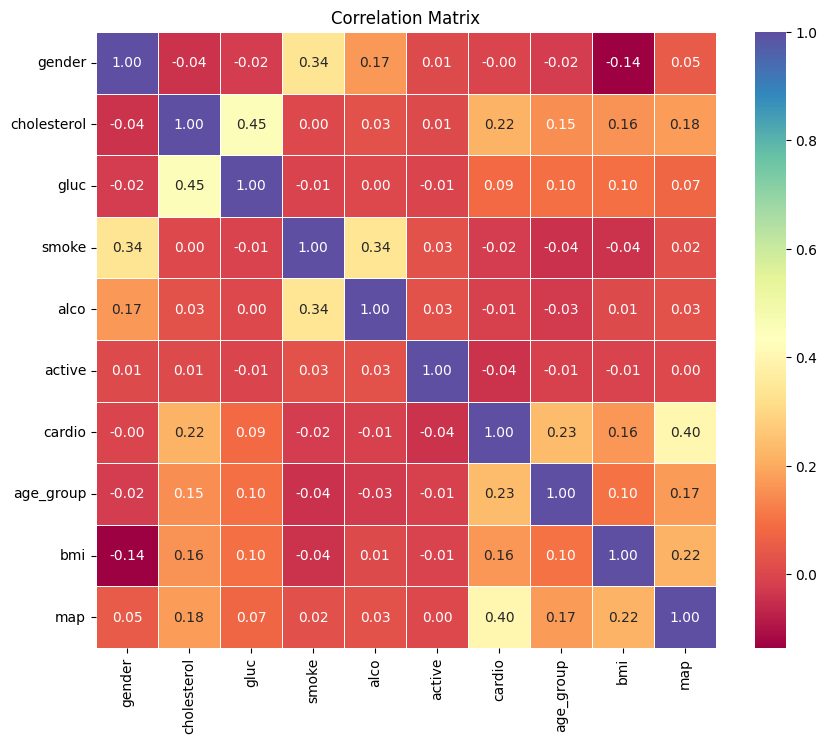

In [16]:
# Set up figure
plt.figure(figsize=(10, 8))

# Draw correlation matrix
sns.heatmap(df.corr(), annot=True, cmap='Spectral', fmt=".2f", linewidths=.5)

# Show the figure
plt.title('Correlation Matrix')
plt.show()

In [17]:
cardio_0 = df[df['cardio'] == 0].sample(n=5000, random_state=42)
cardio_1 = df[df['cardio'] == 1].sample(n=5000, random_state=42)

# Concatenate the sliced dataframes
data = pd.concat([cardio_0, cardio_1])

# Shuffle the data to mix 0s and 1s
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
data.shape


(10000, 10)

In [18]:
x = data.drop(['cardio','gender','alco'], axis=1)
y = data['cardio']

x.head()

,cholesterol,gluc,smoke,active,age_group,bmi,map
0,0,0,0,1,2,2,4
1,0,0,0,1,3,1,2
2,1,1,1,1,4,2,3
3,1,0,1,1,3,2,3
4,0,0,0,0,6,1,2


### Splitting the dataset into train and test

In [19]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=1)

In [20]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 2694 to 235
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   cholesterol  8000 non-null   int64
 1   gluc         8000 non-null   int64
 2   smoke        8000 non-null   int64
 3   active       8000 non-null   int64
 4   age_group    8000 non-null   int64
 5   bmi          8000 non-null   int64
 6   map          8000 non-null   int64
dtypes: int64(7)
memory usage: 500.0 KB


### Function to calculate performance metrics

In [21]:
def calc_metrics(confusion_matrix):
    TP, FN = confusion_matrix[0][0], confusion_matrix[0][1]
    FP, TN = confusion_matrix[1][0], confusion_matrix[1][1]
    TPR = TP / (TP + FN)
    TNR = TN / (TN + FP)
    FPR = FP / (TN + FP)
    FNR = FN / (TP + FN)
    Precision = TP / (TP + FP)
    F1_measure = 2 * TP / (2 * TP + FP + FN)
    Accuracy = (TP + TN) / (TP + FP + FN + TN)
    Error_rate = (FP + FN) / (TP + FP + FN + TN)
    BACC = (TPR + TNR) / 2
    TSS = TPR - FPR
    HSS = 2 * (TP * TN - FP * FN) / ((TP + FN) * (FN + TN) + (TP + FP) * (FP + TN))
    metrics = [TP, TN, FP, FN, TPR, TNR, FPR, FNR, Precision, F1_measure, Accuracy, Error_rate, BACC, TSS, HSS]
    return metrics

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, brier_score_loss, roc_auc_score

def get_metrics(model, X_train, X_test, y_train, y_test, LSTM_flag):
    metrics = []
    
    if LSTM_flag == 1:
        # Convert data to numpy array
        Xtrain, Xtest, ytrain, ytest = map(np.array, [X_train, X_test, y_train, y_test])
        # Reshape data
        shape = Xtrain.shape
        Xtrain_reshaped = Xtrain.reshape(len(Xtrain), shape[1], 1)
        Xtest_reshaped = Xtest.reshape(len(Xtest), shape[1], 1)
        model.fit(Xtrain_reshaped, ytrain, epochs=50, validation_data=(Xtest_reshaped, ytest), verbose=0)
        lstm_scores = model.evaluate(Xtest_reshaped, ytest, verbose=0)
        predict_prob = model.predict(Xtest_reshaped)
        pred_labels = predict_prob > 0.5
        pred_labels_1 = pred_labels.astype(int)
        matrix = confusion_matrix(ytest, pred_labels_1, labels=[1, 0])
        lstm_brier_score = brier_score_loss(ytest, predict_prob)
        lstm_roc_auc = roc_auc_score(ytest, predict_prob)
        metrics.extend(calc_metrics(matrix))
        metrics.extend([lstm_brier_score, lstm_roc_auc, lstm_scores[1]])
        
    elif LSTM_flag == 0:
        model.fit(X_train, y_train)
        predicted = model.predict(X_test)
        matrix = confusion_matrix(y_test, predicted, labels=[1, 0])
        model_brier_score = brier_score_loss(y_test, model.predict_proba(X_test)[:, 1])
        model_roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
        metrics.extend(calc_metrics(matrix))
        metrics.extend([model_brier_score, model_roc_auc, model.score(X_test, y_test)])
    
    return metrics


## Finding best parameters for Random Forest model

In [23]:
# build the model
rfModel = RandomForestClassifier(random_state=42)

# Fit the model
rfModel.fit(x_train, y_train)

# Make predictions
rf_pred = rfModel.predict(x_test)

# accuracy
rf_accuracy = accuracy_score(y_test, rf_pred)*100
print(f"Accuracy without CV: {rf_accuracy:.2f}")

Accuracy without CV: 71.45


In [24]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10, 20],
    'max_features': ['sqrt', 'log2', None],
}

# Create grid search
rf_gridsearch = GridSearchCV(estimator=rfModel,param_grid=param_grid, cv=10, scoring='accuracy',n_jobs=-1)

# Fit grid search
rf_gridsearch.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [100, 200, 300, 500]},
             scoring='accuracy')

In [25]:
rf_best_params = rf_gridsearch.best_params_
best_estimator = rf_gridsearch.best_estimator_

print(f"Best Parameters : {rf_best_params}")
print(f"Best Estimator  : {best_estimator}")

Best Parameters : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 20, 'n_estimators': 100}
Best Estimator  : RandomForestClassifier(max_depth=10, min_samples_split=20, random_state=42)


In [26]:
max_depth = rf_gridsearch.best_params_['max_depth']
min_samples_split = rf_gridsearch.best_params_['min_samples_split']
n_estimators = rf_gridsearch.best_params_['n_estimators']

In [27]:
rf_pred_CV = best_estimator.predict(x_test)

In [28]:
rf_accuracy_cv = accuracy_score(y_test, rf_pred_CV)*100
print(f"Best Accuracy: {rf_accuracy_cv:.2f}")

Best Accuracy: 73.05


In [29]:
print(f"Random Forest accuracy without CV : {rf_accuracy:.2f}")
print(f"Random Forest accuracy with CV    : {rf_accuracy_cv:.2f}")

Random Forest accuracy without CV : 71.45
Random Forest accuracy with CV    : 73.05


## Finding best parameters for the KNN model

In [30]:
knn_parameters = {"n_neighbors": [ 3, 4, 5, 6, 8, 10]}
# Create KNN model
knn_model = KNeighborsClassifier()
# Perform grid search with cross-validation
knn_cv = GridSearchCV(knn_model, knn_parameters, cv=10, n_jobs=-1)
knn_cv.fit(x_train, y_train)
# Print the best parameters found by GridSearchCV
print("\nBest Parameters for KNN based on GridSearchCV: ", knn_cv.best_params_)
print('\n')


Best Parameters for KNN based on GridSearchCV:  {'n_neighbors': 8}




In [31]:
best_n_neighbors = knn_cv.best_params_['n_neighbors']

### Using 10 fold Cross Validation

In [32]:
metric_columns = ['TP', 'TN', 'FP', 'FN', 'TPR', 'TNR', 'FPR', 'FNR', 'Precision',
                  'F1_measure', 'Accuracy', 'Error_rate', 'BACC', 'TSS', 'HSS', 'Brier_score',
                  'AUC', 'Acc_by_package_fn']

# Initialize metrics lists for each algorithm
knn_metrics_list, rf_metrics_list, lstm_metrics_list = [],[],[]

# 10 Iterations of 10-fold cross-validation
cv_stratified = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for iter_num, (train_index, test_index) in enumerate(cv_stratified.split(x, y), start=1):
    # KNN Model
    knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
    
    # Random Forest Model
    rf_model = RandomForestClassifier(min_samples_split=min_samples_split, n_estimators=n_estimators , max_depth= max_depth)
    
    # LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(64, activation='relu', return_sequences=False))
    lstm_model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Get metrics for each algorithm
    knn_metrics = get_metrics(knn_model, x_train, x_test, y_train, y_test, 0)
    rf_metrics = get_metrics(rf_model, x_train, x_test, y_train, y_test, 0)
    lstm_metrics = get_metrics(lstm_model, x_train, x_test, y_train, y_test, 1)
    
    # Append metrics to respective lists
    knn_metrics_list.append(knn_metrics)
    rf_metrics_list.append(rf_metrics)
    lstm_metrics_list.append(lstm_metrics)
    
    # Create a DataFrame for all metrics
    metrics_all_df = pd.DataFrame([knn_metrics, rf_metrics, lstm_metrics],
                                  columns=metric_columns, index=['KNN', 'RF', 'LSTM'])
    
    # Display metrics for all algorithms in each iteration
    print('\nIteration {}: \n'.format(iter_num))
    print('\n----- Metrics for all Algorithms in Iteration {} -----\n'.format(iter_num))
    print(metrics_all_df.round(decimals=2).T)
    print('\n')

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Iteration 1: 


----- Metrics for all Algorithms in Iteration 1 -----

                      KNN      RF    LSTM
TP                 616.00  677.00  692.00
TN                 777.00  778.00  758.00
FP                 219.00  218.00  238.00
FN                 388.00  327.00  312.00
TPR                  0.61    0.67    0.69
TNR                  0.78    0.78    0.76
FPR                  0.22    0.22    0.24
FNR                  0.39    0.33    0.31
Precision            0.74    0.76    0.74
F1_measure           0.67    0.71    0.72
Accuracy             0.70    0.73    0.72
Error_rate           0.30    0.27    0.28
BACC                 0.70    0.73    0.73
TSS                  0.39    0.46    0.45
HSS                  0.39    0.46    0.45
Brier_score          0.21    0.19    0.19
AUC                  0.74    0.79    0.79
Acc_by_package_fn    0.70    0.73    0.73


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Iteration 2: 


----- Metrics for all Algorithms 

In [33]:
# Initialize metric index for each iteration
metric_index_df = ['iter1', 'iter2', 'iter3', 'iter4', 'iter5', 'iter6', 'iter7', 'iter8', 'iter9', 'iter10']

# Create DataFrames for each algorithm's metrics
knn_metrics_df = pd.DataFrame(knn_metrics_list, columns=metric_columns, index=metric_index_df)
rf_metrics_df = pd.DataFrame(rf_metrics_list, columns=metric_columns, index=metric_index_df)
lstm_metrics_df = pd.DataFrame(lstm_metrics_list, columns=metric_columns, index=metric_index_df)

# Display metrics for each algorithm in each iteration
algorithm_names = ['KNN', 'RF', 'LSTM']
for i, metrics_df in enumerate([knn_metrics_df, rf_metrics_df, lstm_metrics_df], start=1):
    print('\nMetrics for Algorithm {}:\n'.format(algorithm_names[i-1]))
    print(metrics_df.round(decimals=2).T)
    print('\n')



Metrics for Algorithm KNN:

                    iter1   iter2   iter3   iter4   iter5   iter6   iter7  \
TP                 616.00  616.00  616.00  616.00  616.00  616.00  616.00   
TN                 777.00  777.00  777.00  777.00  777.00  777.00  777.00   
FP                 219.00  219.00  219.00  219.00  219.00  219.00  219.00   
FN                 388.00  388.00  388.00  388.00  388.00  388.00  388.00   
TPR                  0.61    0.61    0.61    0.61    0.61    0.61    0.61   
TNR                  0.78    0.78    0.78    0.78    0.78    0.78    0.78   
FPR                  0.22    0.22    0.22    0.22    0.22    0.22    0.22   
FNR                  0.39    0.39    0.39    0.39    0.39    0.39    0.39   
Precision            0.74    0.74    0.74    0.74    0.74    0.74    0.74   
F1_measure           0.67    0.67    0.67    0.67    0.67    0.67    0.67   
Accuracy             0.70    0.70    0.70    0.70    0.70    0.70    0.70   
Error_rate           0.30    0.30    0.30    0.

### Average Result for each model

In [34]:
# Calculate the average metrics for each algorithm
knn_avg_df = knn_metrics_df.mean()
rf_avg_df = rf_metrics_df.mean()
lstm_avg_df = lstm_metrics_df.mean()
# Create a DataFrame with the average performance for each algorithm
avg_performance_df = pd.DataFrame({'KNN': knn_avg_df, 'RF': rf_avg_df, 'LSTM': lstm_avg_df}, index=metric_columns)
# Display the average performance for each algorithm
print(avg_performance_df.round(decimals=2))
print('\n')


                      KNN      RF    LSTM
TP                 616.00  676.90  673.60
TN                 777.00  781.50  778.20
FP                 219.00  214.50  217.80
FN                 388.00  327.10  330.40
TPR                  0.61    0.67    0.67
TNR                  0.78    0.78    0.78
FPR                  0.22    0.22    0.22
FNR                  0.39    0.33    0.33
Precision            0.74    0.76    0.76
F1_measure           0.67    0.71    0.71
Accuracy             0.70    0.73    0.73
Error_rate           0.30    0.27    0.27
BACC                 0.70    0.73    0.73
TSS                  0.39    0.46    0.45
HSS                  0.39    0.46    0.45
Brier_score          0.21    0.19    0.19
AUC                  0.74    0.78    0.79
Acc_by_package_fn    0.70    0.73    0.73




### Plotting ROC-SUC Curve for all the models 

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


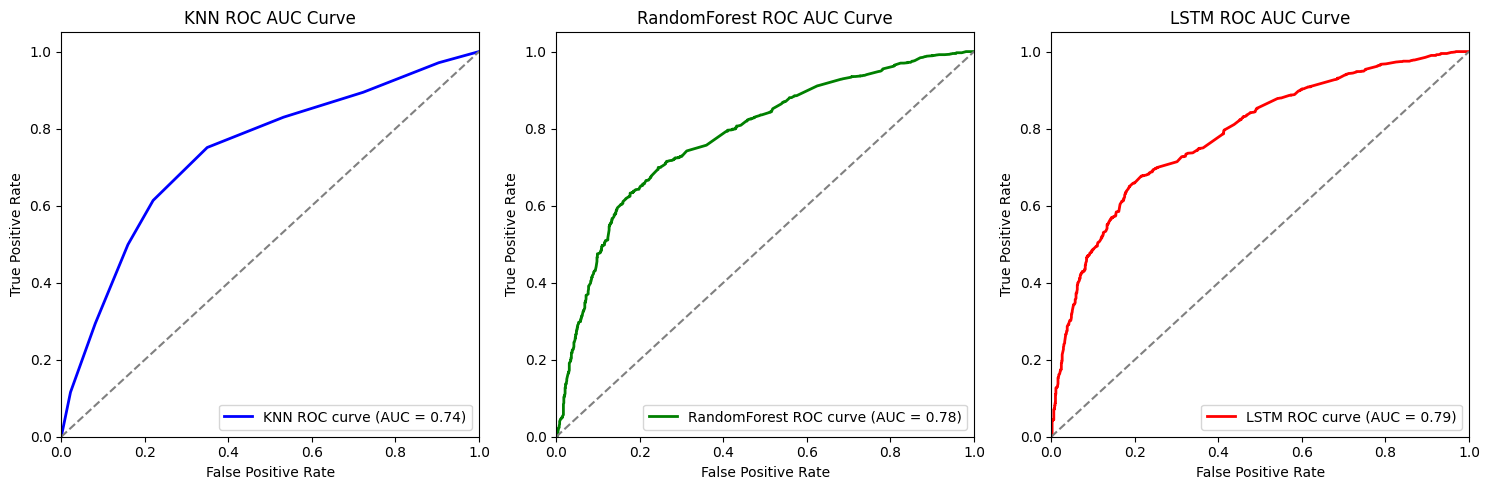

In [35]:
# Train models with best parameters
best_knn_model = KNeighborsClassifier(n_neighbors= best_n_neighbors)
best_rf_model = RandomForestClassifier(n_estimators=rf_best_params['n_estimators'], min_samples_split=rf_best_params['min_samples_split'])

# Fit models
best_knn_model.fit(x_train, y_train)
best_rf_model.fit(x_train, y_train)

#lstm model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', return_sequences=False))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert data to numpy array
X_train_array = x_train.to_numpy()
X_test_array = x_test.to_numpy()
y_train_array = y_train.to_numpy()
y_test_array = y_test.to_numpy()

# Reshape data for LSTM model compatibility
input_shape = X_train_array.shape
input_train = X_train_array.reshape(len(X_train_array), input_shape[1], 1)
input_test = X_test_array.reshape(len(X_test_array), input_shape[1], 1)
output_train = y_train_array
output_test = y_test_array

# Train the LSTM model
history = lstm_model.fit(input_train, output_train, epochs=50, validation_data=(input_test, output_test), verbose=0)

# Predict probabilities for test set
knn_probs = best_knn_model.predict_proba(x_test)[:, 1]
rf_probs = best_rf_model.predict_proba(x_test)[:, 1]
lstm_probs = lstm_model.predict(x_test).ravel()  # Assuming lstm_model is already trained

# Calculate ROC AUC scores
knn_fpr, knn_tpr, _ = roc_curve(y_test, knn_probs)
knn_roc_auc = auc(knn_fpr, knn_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
rf_roc_auc = auc(rf_fpr, rf_tpr)

lstm_fpr, lstm_tpr, _ = roc_curve(y_test, lstm_probs)
lstm_roc_auc = auc(lstm_fpr, lstm_tpr)

# Plot ROC AUC curves
plt.figure(figsize=(15, 5))

# KNN ROC AUC curve
plt.subplot(1, 3, 1)
plt.plot(knn_fpr, knn_tpr, color='blue', lw=2, label='KNN ROC curve (AUC = %0.2f)' % knn_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC AUC Curve')
plt.legend(loc="lower right")

# RandomForest ROC AUC curve
plt.subplot(1, 3, 2)
plt.plot(rf_fpr, rf_tpr, color='green', lw=2, label='RandomForest ROC curve (AUC = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RandomForest ROC AUC Curve')
plt.legend(loc="lower right")

# LSTM ROC AUC curve
plt.subplot(1, 3, 3)
plt.plot(lstm_fpr, lstm_tpr, color='red', lw=2, label='LSTM ROC curve (AUC = %0.2f)' % lstm_roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM ROC AUC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()
